First, we add all the necessary packages.

In [1]:
using Pkg
Pkg.activate(".")

using PythonCall,CondaPkg
JEft=pyimport("justetf_scraping")

using CairoMakie
using Serialization, CSV, DataFrames, Dates
using Statistics, CovarianceEstimation, Random
using LinearAlgebra 
using NLopt, JuMP

include("src/src.jl")

  Activating project at `~/Codes/portfolio`
    CondaPkg Found dependencies: /home/nikolay/Codes/portfolio/CondaPkg.toml
    CondaPkg Found dependencies: /home/nikolay/.julia/packages/PythonCall/Nr75f/CondaPkg.toml
    CondaPkg Dependencies already up to date


get_R_RR_cor (generic function with 1 method)

Parameters:
- `shift`: a period of time in days over which all the returns will be evaluated.
- `risk_free_return`: the return over `shift` period of time considered risk free, e.g. bank deposit.
- `half_life`: to compute mean return over `shift` period we use weighted means. The data at the day `today-half_life` will have weight two times smaller than the data from `today`.
- `correlation_threshold`: at some moment we will filter our tickers so that no tickers with correlation above the given threshold are left.
- `update_charts_q`: if `true`, the fresh charts from justETF will be downloaded (this will take around 30 minutes). If `false`, the charts will be loaded from the data folder. If there is no charts there, charts will be loaded from justETF.
- `data_starting_date`: ETS that don't have data earlier than this will be thrown away.
- `unaccessible_tickers`: a list of tickers that one cannot buy for some reason.

In [33]:
shift=365;
risk_free_return=0.0325;
half_life=4;
correlation_threshold=0.85;
update_charts_q=false;
data_starting_date=Date(2019);
unaccessible_tickers=["DE000EWG2LD7", "DE000A0S9GB0", "DE000EWG0LD1"];

We create two tables with data:
 - `DO` stands for "Data Overview". There, each row corresponds to a particular ticker. Contains some general information.
 - `DC` stands for "Data Charts". There, the first column contains all the dates and the rest of the columns corresponds to values of tickers.

In [3]:

tmp=JEft.load_overview(strategy="epg-longOnly")
tmp.to_csv("tmp.csv")
DO=CSV.read("tmp.csv", DataFrame)
rm("tmp.csv");

if update_charts_q
    DC=up_to_date_charts(DO)
else
    if isfile("data/charts.csv")
        DC=CSV.read("data/charts.csv", DataFrame)
    else
        DC=up_to_date_charts(DO)
    end
end

/home/nikolay/Codes/portfolio/.CondaPkg/env/lib/python3.11/site-packages/justetf_scraping/overview.py:407: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[column] = df[column].replace({"Yes": True, "No": False}).astype("bool")
/home/nikolay/Codes/portfolio/.CondaPkg/env/lib/python3.11/site-packages/justetf_scraping/overview.py:407: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[column] = df[column].replace({"Yes": True, "No": False}).astype("bool")


Row,date,IE00B5BMR087,IE00B4L5Y983,IE00B3XXRP09,IE00B3YCGJ38,IE00BKM4GZ66,IE0031442068,IE00BFMXXD54,IE00B4ND3602,IE00B579F325,IE00B6R52259,IE00B53SZB19,IE00B3RBWM25,IE00BK5BQT80,IE0005042456,DE000A0S9GB0,IE00BJ0KDQ92,IE00B6YX5C33,IE00BLNMYC90,IE00BGSF1X88,LU0290358497,IE00BF4G7076,IE00B3F81R35,IE00B4X9L533,IE00BHZPJ890,IE00BFY0GT14,IE00B3WJKG14,IE00BFMNPS42,IE00BJ0KDR00,LU0908500753,IE00BFNM3G45,IE0032077012,LU1135865084,IE00B1YZSC51,IE00BYX2JD69,IE00B4K48X80,IE00BHZPJ908,FR0010315770,IE00BMTX1Y45,IE00BZ02LR44,IE00B0M62Q58,DE0005933956,IE00B5KQNG97,IE00BLF7VX27,IE00B3ZW0K18,IE00B66F4759,LU1781541179,DE0005933931,IE000XZSV718,DE0002635307,IE00BF4G6Y48,LU2009147757,IE00B60SX394,IE00B3VWN393,IE00BTJRMP35,IE00B60SX170,IE000KXCEXR3,IE00BZCQB185,IE00B4WXJJ64,DE000A2T0VU5,LU2572257124,IE00B4L5YX21,IE00BYVJRR92,IE00BYML9W36,IE00B8GKDB10,FR0013416716,IE00BGHQ0G80,LU0274210672,IE00BYXYYP94,JE00B1VS3770,IE00BH4GPZ28,LU0490618542,IE00BF4RFH31,IE0032895942,LU0274208692,LU0274211480,LU0629459743,IE00BM67HT60,DE000A0F5UF5,IE00B0M63177,IE00BJ38QD84,LU1437018168,IE00B810Q511,IE00BHZPJ239,IE00BYXPSP02,IE00B2NPKV68,LU1681043599,LU1681049018,IE00B53L3W79,IE00B1FZS798,IE00B4YBJ215,LU0274209237,IE00BP3QZ601,IE00BHZPJ569,IE000Y77LGG9,IE00BYZTVT56,IE00BYXYYM63,IE00BHZPJ676,IE00BGV5VN51,LU0380865021,⋯
,Date,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,⋯
1,2000-04-03,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,⋯
2,2000-04-04,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,⋯
3,2000-04-05,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,

Now, we create the conditioned tables `DO_acc` and `DC_acc`. In these tables we have only accumulating ETFs with the fund size of at least 50 millions euro. Furthermore, we throw away ETFs which don't have data at least up to `data_starting_date` unless we can compensate it using the data from distributing ETF version.

In [5]:
conditions=(DO.dividends.=="Accumulating") .& (DO.size .|> x -> ismissing(x) ? false : x>=50 )

DO_acc=DO[conditions,:]
DC_acc=DC[:,["date",DO_acc.isin...]]


tickers_to_remove=Vector{Int}()
for i=2:length(names(DC_acc))
    tk=names(DC_acc)[i]
    tk_vals=DC_acc[!,tk]

    tk_first_day_index=findfirst(x->!(ismissing(x)),tk_vals)

    if DC_acc[tk_first_day_index,"date"]>data_starting_date
        tk_dist_name=dist_name(DO[DO.isin.==tk,:name]...)
        tk_dist=begin tmp = DO[DO.name.==tk_dist_name,:isin]; length(tmp)>0 ? tmp[1] : nothing end
        
        if !(isnothing(tk_dist))
            tk_dist_vals=DC[!,tk_dist]
            tk_dist_first_day_index=findfirst(x->!(ismissing(x)),tk_dist_vals)
            if DC[tk_dist_first_day_index,"date"] <= data_starting_date
                DC_acc[!,tk].=DC[!,tk_dist]
                println("Data in $tk was replaced with data in $(tk_dist)")
            end
            println("$tk does not have enough data and its distributing version does not have it either. $tk will be removed from the database.")
            push!(tickers_to_remove,i-1)
        else
            println("$tk does not have enough data and there is no distributing version of it to compensate. $tk will be removed from the database.")
            push!(tickers_to_remove,i-1)
        end
    else
        println("$tk has enough data")
    end
end

println("Removing tickers with not enough data and unaccessible tickers.")
DO_acc=DO_acc[Not(tickers_to_remove),:]
DO_acc=DO_acc[Not(DO_acc.isin .|> x->x∈unaccessible_tickers),:]
DC_acc=DC_acc[:,["date",DO_acc.isin...]];

IE00B5BMR087 has enough data
IE00B4L5Y983 has enough data
IE00B3YCGJ38 has enough data
IE00BKM4GZ66 has enough data
Data in IE00BFMXXD54 was replaced with data in IE00B3XXRP09
IE00BFMXXD54 does not have enough data and its distributing version does not have it either. IE00BFMXXD54 will be removed from the database.
IE00B4ND3602 has enough data
IE00B579F325 has enough data
IE00B6R52259 has enough data
IE00B53SZB19 has enough data
Data in IE00BK5BQT80 was replaced with data in IE00B3RBWM25
IE00BK5BQT80 does not have enough data and its distributing version does not have it either. IE00BK5BQT80 will be removed from the database.
DE000A0S9GB0 has enough data
IE00BJ0KDQ92 has enough data
IE00BLNMYC90 has enough data
IE00BGSF1X88 does not have enough data and there is no distributing version of it to compensate. IE00BGSF1X88 will be removed from the database.
LU0290358497 has enough data
IE00BF4G7076 has enough data
IE00BFY0GT14 does not have enough data and there is no distributing version 

Let us take a random ticker and plot its behavior to compare with the website.

ticker: LU1291109616


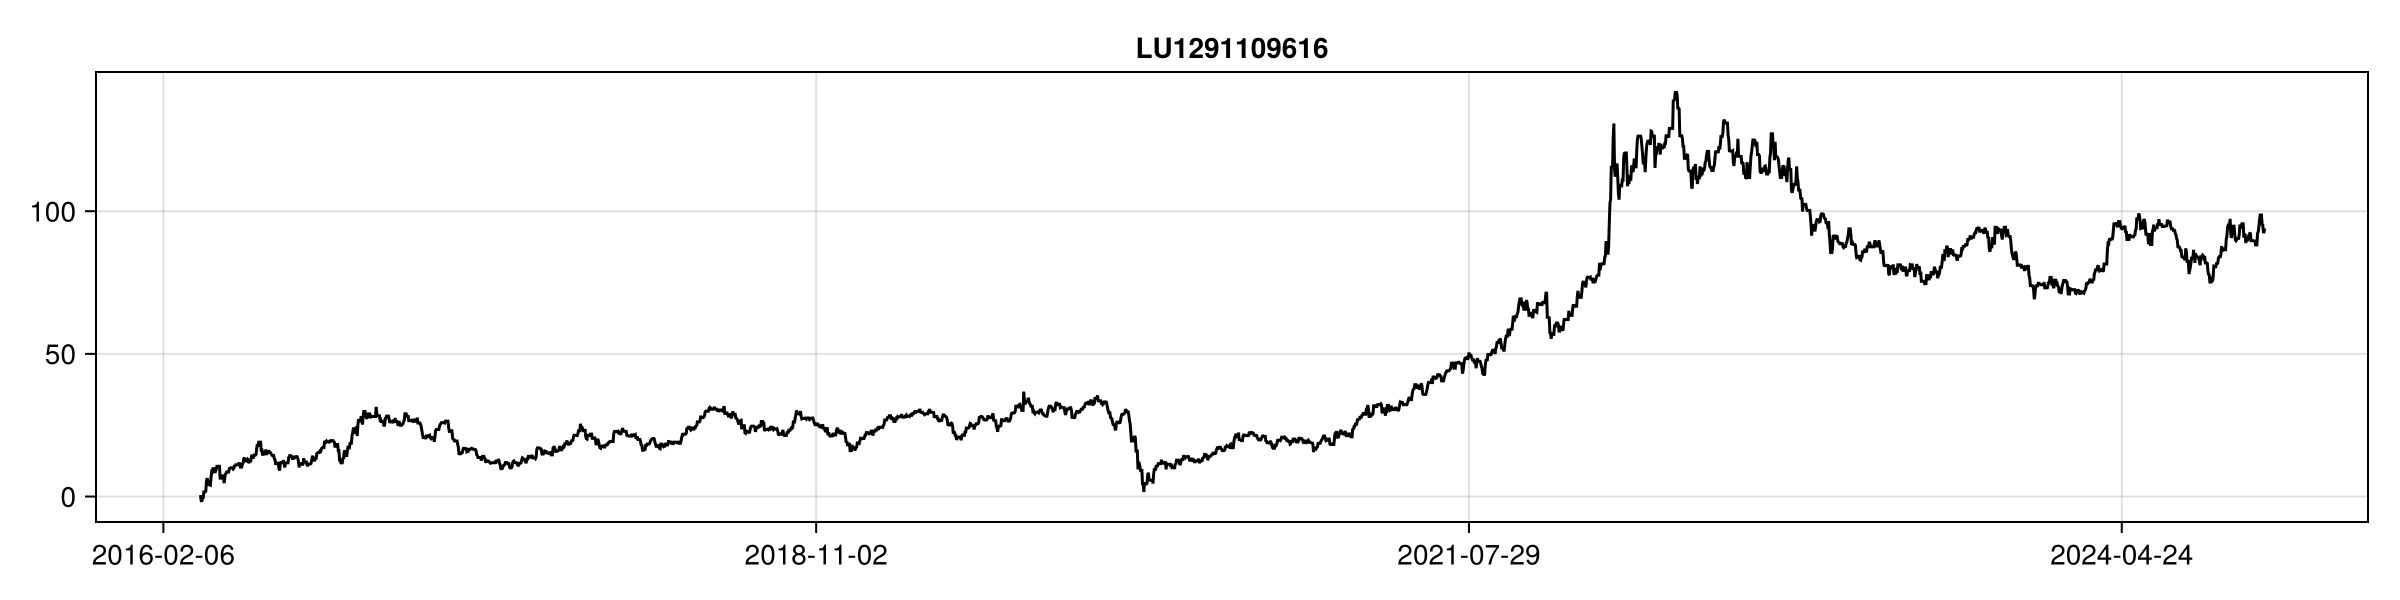

In [6]:
tk=rand(names(DC_acc))
println("ticker: ", tk)
fig=Figure(;size=(1200,300))
ax=Axis(fig[1,1], title=tk)
lines!(ax,DC_acc[!,:date],DC_acc[!,tk].-100; color=:black)
fig

Now, we will reduce the number of tickers further by dividing them into highly correlated groups and choosing only one ticker from each group (the one with the highest Sharpe ratio). For this, we will need compute the expectation values `R` and covariance matrix `RR` of the annual returns. We also compute the correlation matrix `cor`, which is a normalized version of the covariance matrix. We will use `cor` to distinguish the correlated assets and `R`, `RR` to compute the Sharpe ratio. 

We compute the covariance matrix by using so called shrinkage estimators. I don't know much about these and use the method here more or less blindly. The idea is that if we don't have a lot of data point (comparing with the number of tickers) then the standard method can be unstable. Shrinkage estimators are supposed to make the result a bit more reliable.

In [31]:
R,RR,cor=get_R_RR_cor(DC_acc, shift, half_life);
cor

679×679 Matrix{Float64}:
  1.0         0.959349   0.972782   …   0.353279    0.739932   0.287663
  0.959349    1.0        0.958988       0.37059     0.802907   0.255307
  0.972782    0.958988   1.0            0.352395    0.738676   0.289571
  0.777259    0.831997   0.776307       0.113646    0.805728   0.266495
 -0.0823647  -0.173584  -0.0805767     -0.408632   -0.283306   0.523591
 -0.0833562  -0.174842  -0.0815514  …  -0.411654   -0.284068   0.525752
  0.951257    0.968414   0.950827       0.348172    0.817618   0.260305
  0.746752    0.738308   0.747129      -0.240214    0.621691   0.627888
  0.959268    0.970808   0.958928       0.368873    0.803264   0.256834
  0.873564    0.889497   0.872887       0.555534    0.680742   0.00627948
  ⋮                                 ⋱                         
  0.680657    0.747438   0.679417   …   0.709749    0.75016   -0.212141
  0.827242    0.86424    0.827021       0.0307047   0.788227   0.485963
  0.397547    0.388985   0.398691      -0.5026

We have now correlation matrix, let us look at how tickers with correlations above certain threshold behave. The following cell will chose a random ticker, take `nsample` tickers whose correlation with it lies inside the `correlation_interval` and plot their behavior. The red line is the chosen ticker and the gray lines is the correlated tickers. To make the comparison simpler, all the lines are shifted so that the last point is at zero.

chosen ticker: LU0476289540
amount of tickers in the correlation interval: 97


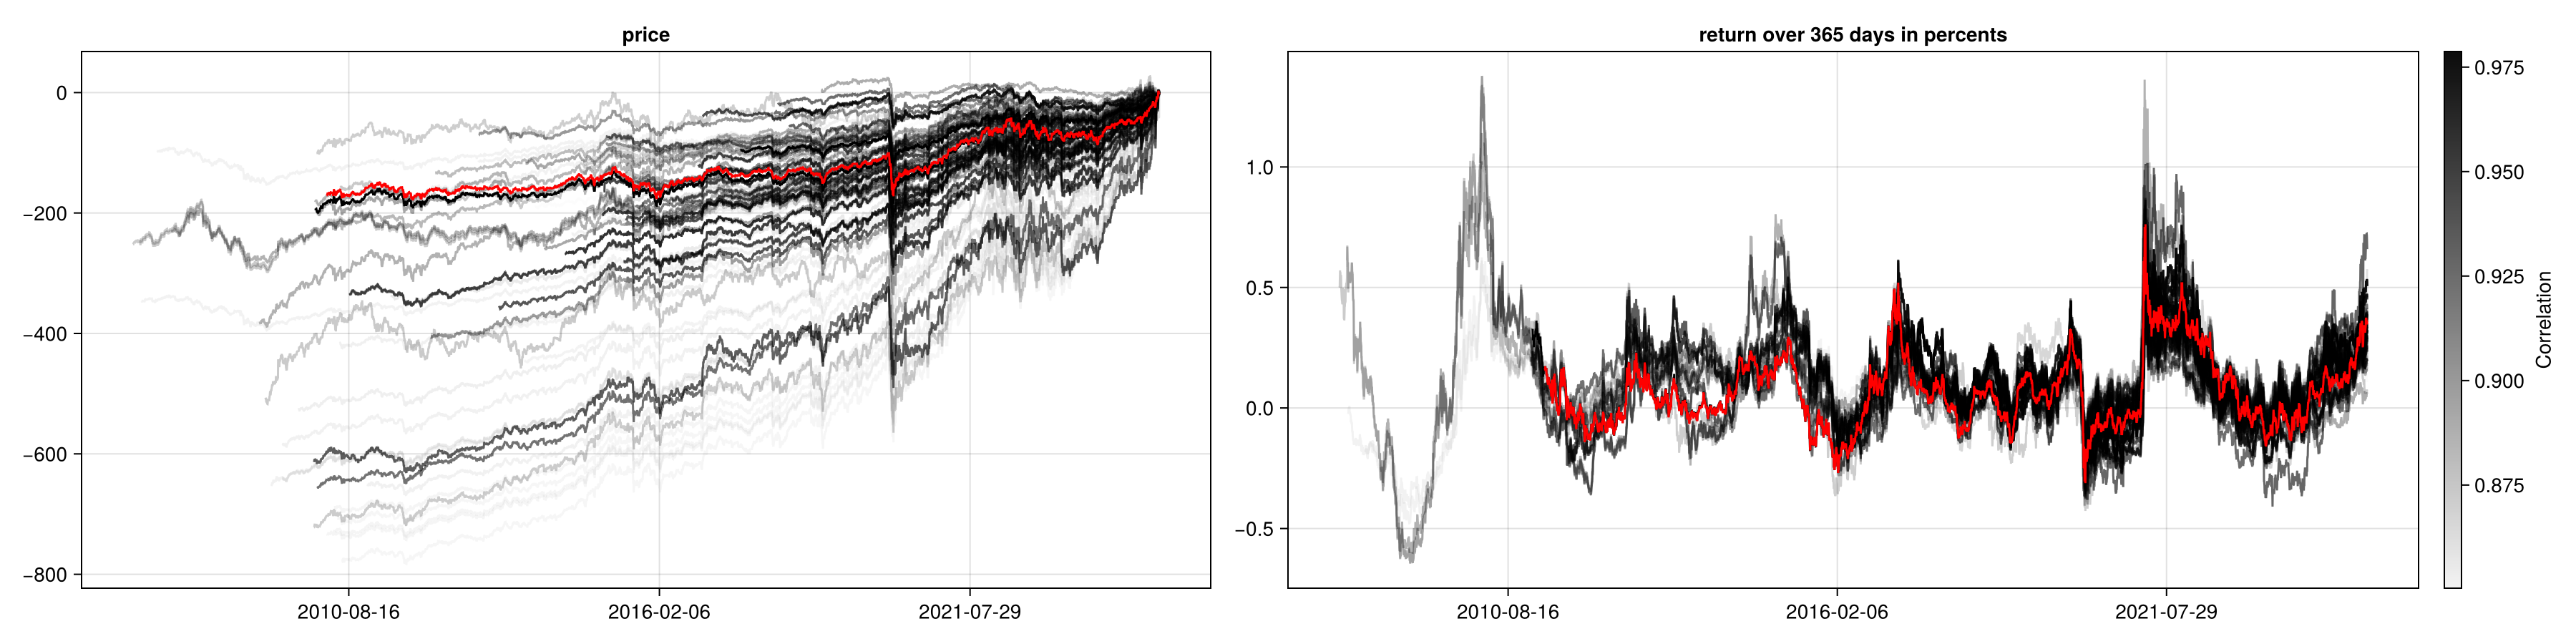

In [32]:
correlation_interval=[0.85,1.0]
nsample=100

i=rand(1:size(DO_acc,1))
tk=names(DC_acc)[i+1]

println("chosen ticker: $tk")

tk_cor=cor[:,i]

if count(tk_cor .|> (x-> x>correlation_interval[1] && x<correlation_interval[2]))>1

    correlated_tickers=names(DC_acc)[2:end][tk_cor .|> (x-> x>correlation_interval[1] && x<correlation_interval[2])]
    correlation_values=tk_cor[tk_cor .|> (x-> x>correlation_interval[1] && x<correlation_interval[2])]

    correlation_color=(correlation_values.-findmin(correlation_values)[1])./(findmax(correlation_values)[1]-findmin(correlation_values)[1])
    println("amount of tickers in the correlation interval: $(length(correlated_tickers))")

    fig=Figure(;size=(1800,450))
    ax=Axis(fig[1,1], title="price")

    for i in 1:min(nsample,length(correlated_tickers))
        tkc=correlated_tickers[i]    
        sh=collect(skipmissing(DC_acc[:,tkc]))[end]
        lines!(ax,DC_acc[!,"date"], DC_acc[!,tkc].-sh,color=(:black, (correlation_color[i])))
    end

    sh=collect(skipmissing(DC_acc[:,tk]))[end]
    lines!(ax,DC_acc[!,"date"], DC_acc[!,tk].-sh, color=:red)
    
    ax=Axis(fig[1,2], title="return over $shift days in percents")


    for i in 1:min(nsample,length(correlated_tickers))
        tkc=correlated_tickers[i]    
        lines!(ax, DC_acc[(1+shift):end,"date"] ,percent_return(DC_acc[:,tkc],shift),color=(:black, (correlation_color[i])))
    end

    lines!(ax,DC_acc[(1+shift):end,"date"], percent_return(DC_acc[!,tk],shift), color=:red)

    color_range = (minimum(correlation_values),maximum(correlation_values))
    cmap = :grays

    cbar = Colorbar(fig[1,3], colormap=Reverse(cmap), limits=color_range,
    flipaxis=true, label="Correlation")


    fig 
else
    println("Ticker is not correlated with other tickers in the given correlation interval, please try again.")
end


The cell below runs the correlation reducing procedure resulting in the data collection `DC_acc_cr` such that non of two tickers in `DC_acc_cr` are correlated above `correlation_theshold`. After the procedure is done, we also define the data collection `DO_acc_cr` with general information about tickers from `DC_acc_cr`. 

In [34]:
DC_acc_cr=copy(DC_acc)
R,RR,cor=get_R_RR_cor(DC_acc_cr, shift, half_life);

while length(cor[cor.>correlation_threshold])>size(cor,1)
    R,RR,cor=get_R_RR_cor(DC_acc_cr, shift, half_life)
    println(size(cor,1))


    cnt=1
    ct_filter=(cor[:,cnt].>correlation_threshold)
    while cnt<=length(R)
        ct_filter=(cor[:,cnt].>correlation_threshold)
        if count(ct_filter)>1
            break
        end
        cnt+=1
    end

    if cnt>length(R)
        break
    end

    correlated_tickers_ind=findall(x->x==true, ct_filter)

    sharpe_ratios=[]
    for tk ∈ correlated_tickers_ind
        push!(sharpe_ratios,(R[tk]-risk_free_return)/(sqrt(RR[tk,tk])))
    end
    best_ticker_ind=correlated_tickers_ind[findmax(sharpe_ratios)[2]]
    
    filter!(x->x!=best_ticker_ind,correlated_tickers_ind)

    tickers_to_remove=names(DC_acc_cr)[2:end][correlated_tickers_ind]

    DC_acc_cr=DC_acc_cr[!,Not(tickers_to_remove)]
end

DO_acc_cr=DO_acc[DO_acc.isin .|> (x->x ∈ names(DC_acc_cr)), :]

679
542
471
464
440
439
352
348
338
309
289
286
284
281
262
255
246
235
203
200
197
192
186
184
179
174
171
169
166
163
162
161
158
157
154
149
145
143
139
137
136
135
134
132
128
126
125
124
123
122
120
119
117
116
115
113
112
110


Row,isin,wkn,ticker,valor,name,inception_date,age_in_days,age_in_years,strategy,domicile_country,currency,hedged,securities_lending,dividends,ter,replication,size,is_sustainable,number_of_holdings,yesterday,last_week,last_month,last_three_months,last_six_months,last_year,last_three_years,last_five_years,2023,2022,2021,2020,last_dividends,last_year_dividends,last_year_volatility,last_three_years_volatility,last_five_years_volatility,last_year_return_per_risk,last_three_years_return_per_risk,last_five_years_return_per_risk,max_drawdown,last_year_max_drawdown,last_three_years_max_drawdown,last_five_years_max_drawdown
,String15,String7?,String7,String15?,String,Date,Int64,Float64,String15,String15,String3,Bool,Bool,String15,Float64,String31,Int64?,Bool,Int64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64,Float64?,Float64?,Float64?
1,LU0290358497,DBX0AN,XEON,3220328,Xtrackers II EUR Overnight Rate Swap UCITS ETF 1C,2007-05-25,6401,17.537,Long-only,Luxembourg,EUR,false,false,Accumulating,0.1,Swap based Unfunded,11300,false,missing,3.52,0.08,0.28,0.87,1.82,3.85,6.82,5.6,3.27,-0.03,-0.58,-0.57,missing,missing,0.15,0.17,0.17,25.71,12.88,6.63,-3.7,0.0,-0.41,-1.55
2,IE00B3WJKG14,A142N1,QDVE,30453015,iShares S&P 500 Information Technology Sector UCITS ETF USD (Acc),2015-11-20,3300,9.0411,Long-only,Ireland,USD,false,true,Accumulating,0.15,Full replication,9498,false,69,41.65,-1.13,3.48,11.44,17.67,45.91,66.46,215.6,52.08,-23.98,44.56,30.56,missing,missing,22.36,26.05,28.32,2.05,0.71,0.91,-31.62,-16.95,-26.68,-31.62
3,IE00B3VWN393,A0X8SH,SXRL,10200795,iShares USD Treasury Bond 3-7yr UCITS ETF (Acc),2009-06-03,5661,15.5096,Long-only,Ireland,USD,false,true,Accumulating,0.07,Sampling,5490,false,90,7.57,-0.42,3.01,4.45,6.71,9.15,3.58,5.52,0.87,-3.85,5.68,-2.02,missing,missing,6.94,9.65,8.65,1.32,0.12,0.12,-17.3,-3.15,-12.9,-13.62
4,IE00BYXYYP94,A2DN9V,IS09,36324506,iShares USD Short Duration Corporate Bond UCITS ETF (Acc),2017-04-13,2790,7.64384,Long-only,Ireland,USD,false,true,Accumulating,0.2,Sampling,4657,false,2689,9.75,-0.88,2.93,6.03,6.43,10.61,13.05,14.66,1.99,1.41,7.83,-4.56,missing,missing,6.4,8.34,7.71,1.65,0.5,0.36,-14.65,-2.77,-11.78,-11.78
5,IE00BZ043R46,A2DWBL,QDVJ,37977783,iShares Core Global Aggregate Bond UCITS ETF USD Hedged (Acc),2017-11-21,2568,7.03562,Long-only,Ireland,USD,true,true,Accumulating,0.1,Sampling,3802,false,15991,8.87,-0.38,3.53,5.81,7.54,11.39,4.55,5.39,2.97,-5.99,6.37,-3.88,missing,missing,6.77,9.06,8.31,1.68,0.17,0.13,-12.24,-2.55,-12.24,-12.24
6,GB00B00FHZ82,A0CANA,GG9B,missing,Gold Bullion Securities,2004-03-31,7551,20.6877,Long-only,Jersey,USD,false,false,Accumulating,0.4,Physically backed,2837,false,missing,34.64,-2.56,-1.83,11.15,15.91,34.81,57.35,85.6,9.4,5.32,3.69,13.46,missing,missing,14.68,14.61,15.24,2.36,1.11,0.86,-37.55,-6.01,-11.92,-18.33
7,IE00BFM6TC58,A2JKTZ,SXRC,41533873,iShares USD Treasury Bond 20+yr UCITS ETF USD (Acc),2018-05-10,2398,6.56986,Long-only,Ireland,USD,false,true,Accumulating,0.07,Sampling,2468,false,41,2.78,2.3,4.47,3.02,9.09,9.9,-26.12,-21.14,-0.46,-27.06,3.12,8.05,missing,missing,14.89,19.01,18.64,0.66,-0.5,-0.25,-46.57,-9.32,-39.77,-46.57
8,IE00B1FZSC47,A0LGP8,IUST,2803924,iShares USD TIPS UCITS ETF USD (Acc),2006-12-08,6569,17.9973,Long-only,Ireland,USD,false,true,Accumulating,0.1,Sampling,2402,false,48,8.21,-0.46,2.8,5.13,6.46,10.19,0.57,15.23,0.17,-6.9,14.29,1.89,missing,missing,7.42,10.65,9.86,1.37,0.02,0.29,-20.15,-2.59,-15.36,-15.36
9,LU1190417599,LYX0WM,LYOR,27128159,Lyxor Smart Overnight Return UCITS ETF C-EUR,2015-03-02,3563,9.76164,Long-only,Luxembourg,EUR,false,false,Accumulating,0.1,Swap based Unfunded,2366,false,missing,3.68,0.07,0.31,0.93,1.98,4.05,7.19,6.24,3.28,0.13,-0.46,-0.44,missing,missing,0.24,0.19,0.93,16.99,12.05,1.3,-2.37,-0.04,-0.29,-1.2


Before going to the optimization, let us define some parameters:
 - `USD_bound`: gives a constrain on the total amount of the USD based tickers
 - `entropy_factor`: we add entropy times `entropy_factor` into the objective function to improve diversification.
 - `lowest_share`: if not zero, the code will run optimization twice. In the second time, only tickers with share (in the previous solution) larger than `lowest_share` will be used. 

In [133]:
USD_filter=DO_acc_cr.currency.=="USD"
USD_bound=0.6
entropy_factor=0.1;
lowest_share=0.01;

Now, let us proceed to the optimization. For now I am using some local optimization technique. Sometimes it finds local minima, but after a few re-runs we may hope to find a good solution (a random starting point is used). Clearly, this is something that could be improved in the future. The local minima become a problem when we try to optimize using more tickers, e.g. for high `correlation_threshold`.

In [134]:
R,RR,cor=get_R_RR_cor(DC_acc_cr, shift, half_life)

function entropy(w)
    -sum((w).*log.(w))
end
function sharpe_ratio(w) 
    return (dot(R,w)-risk_free_return)/sqrt(dot(w,RR*w))
end
function objective(w)
    return sharpe_ratio(w)+entropy_factor*entropy(w)
end

model=Model(NLopt.Optimizer)
@variable(model, 0<=w[1:length(R)]<=1)
@objective(model,Max,objective(w))
@constraint(model, sum(w)==1)
@constraint(model, sum(w[USD_filter])<=USD_bound)


set_attribute(model, "algorithm", :LD_SLSQP)
set_attribute(model, "constrtol_abs", 1e-8)
set_attribute(model, "ftol_rel", 1e-8)

w0=rand(length(R))
w0/=sum(w0)
set_start_value.(w, w0)

JuMP.optimize!(model)

if !is_solved_and_feasible(model)
    throw("Optimizer did not find a solution!")
end

println("termination status: ", termination_status(model))

w_opt=value.(w)
sr0=dot(R,w_opt)/sqrt(dot(w_opt,RR*w_opt))

println(raw_status(model), "| objective: ", objective_value(model), " entropy: ", entropy(w_opt), " return: ", dot(R,w_opt), " risk: ", sqrt(dot(w_opt,RR*w_opt)), " return/risk ratio: ", sr0)

if lowest_share!=0
    println("Now, the optimization problem ill be restricted to the tickers with more than $(lowest_share*100)%")
    low_share_filter=w_opt.<=lowest_share
    @constraint(model, sum(w[low_share_filter])<=1e-10)
    
    set_start_value.(w, w_opt)
    JuMP.optimize!(model)

    if !is_solved_and_feasible(model)
        throw("Optimizer did not find a solution!")
    end

    println("termination status: ", termination_status(model))
    w_opt=value.(w)
    sr0=dot(R,w_opt)/sqrt(dot(w_opt,RR*w_opt))

    println(raw_status(model), "| objective: ", objective_value(model), " entropy: ", entropy(w_opt), " return: ", dot(R,w_opt), " risk: ", sqrt(dot(w_opt,RR*w_opt)), " return/risk ratio: ", sr0)
end

termination status: LOCALLY_SOLVED
FTOL_REACHED| objective: 2.000790241094179 entropy: 2.2670858127372333 return: 0.12221329339923032 risk: 0.050568863559701985 return/risk ratio: 2.4167696245525545
Now, the optimization problem ill be restricted to the tickers with more than 1.0%
termination status: LOCALLY_SOLVED
FTOL_REACHED| objective: 1.9967992301743558 entropy: 2.066636780202106 return: 0.12438689598212761 risk: 0.05132957438421702 return/risk ratio: 2.4232987994612025


In [135]:
p=sortperm(w_opt; rev=true)
names_ordered=DO_acc_cr.name[p]
w_opt_ord=w_opt[p]
for i=1:length(w_opt_ord)
    println(names_ordered[i], " | ", round(w_opt_ord[i]*100; digits=0),"%")
end

iShares S&P 500 Information Technology Sector UCITS ETF USD (Acc) | 29.0%
Amundi MSCI Turkey UCITS ETF Acc | 15.0%
Amundi Euro Inflation Expectations 2-10Y UCITS ETF Acc | 14.0%
Gold Bullion Securities | 12.0%
iShares Bloomberg Roll Select Commodity Swap UCITS ETF USD | 11.0%
Invesco US Health Care Sector UCITS ETF | 6.0%
Amundi S&P 500 VIX Futures Enhanced Roll UCITS ETF Acc | 4.0%
SPDR Refinitiv Global Convertible Bond CHF Hedged UCITS ETF | 3.0%
SPDR MSCI Europe Utilities UCITS ETF | 2.0%
Xtrackers CSI 300 Swap UCITS ETF 1C | 2.0%
Xtrackers Singapore Government Bond UCITS ETF 1C | 2.0%
iShares S&P 500 Consumer Staples Sector UCITS ETF | 0.0%
iShares MSCI Mexico Capped UCITS ETF (Acc) | 0.0%
BNP Paribas Easy MSCI Japan ESG Filtered Min TE UCITS ETF EUR Hedged | 0.0%
UBS ETF (LU) Bloomberg TIPS 1-10 UCITS ETF (hedged to CHF) A-acc | 0.0%
iShares MSCI Japan USD Hedged UCITS ETF (Acc) | 0.0%
UBS ETF (LU) Bloomberg US Liquid Corporates 1-5 Year UCITS ETF (hedged to CHF) A-acc | 0.0%
SPDR

Let us now look at the historical performance of this portfolio (with weights rounded to integers).

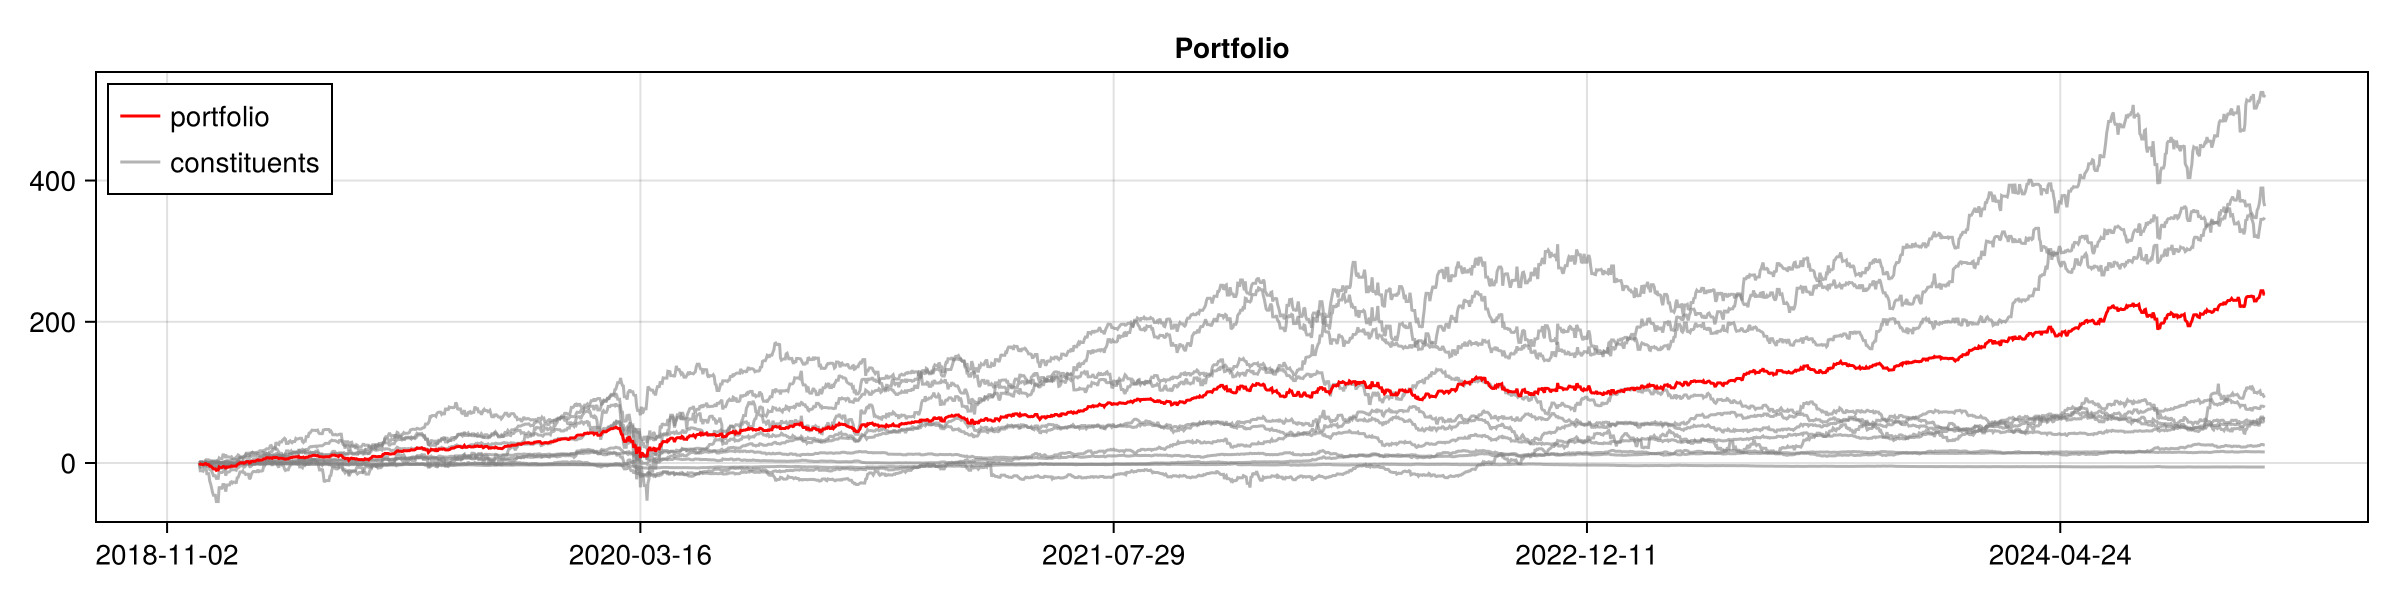

In [136]:
w_opt_round=round.(w_opt; digits=2);

DC_acc_cr_nrm=dropmissing(DC_acc_cr)
mapcols!(x->x.-x[1].+100,DC_acc_cr_nrm; cols=Not("date"))

portfolio_value=sum(Matrix(reshape(w_opt_round,1,length(w_opt_round)).*DC_acc_cr_nrm[!,Not("date")]); dims=2)[:]

fig=Figure(;size=(1200,300))
ax=Axis(fig[1,1], title="Portfolio")

# Plot constituents first
constituent_line = nothing
for tk in names(DC_acc_cr_nrm)[2:end][w_opt_round.>1e-10]
    constituent_line = lines!(ax,DC_acc_cr_nrm[!,"date"], DC_acc_cr_nrm[!,tk].-100; color=(:gray,0.6))
end

# Plot portfolio
portfolio_line = lines!(ax,DC_acc_cr_nrm[!,"date"], portfolio_value.-100; color=:red)

# Add legend
axislegend(ax, [portfolio_line, constituent_line], ["portfolio", "constituents"], position=:lt)

fig

Improvement ideas:
1. Understand better the covariance matrix computation as now we are using it blindly.
2. Use global optimization techniques. See documentation of NLopt. 
3. How about measuring risk a bit differently? The following idea may not lead anywhere as it is rare that we have soem sudden jumps up which are not compensated by sudden jumps down. However, what if we will measure risk not as the variance of the return distribution, but as mean value of negative returns only?
   